In this notebook we will explore the different GPS data that we have available, trying to find the more accurate one.  
Using those GPS coordinates we compute the distance between two given points. The GPS data that we have comes from:
1. [Garmin VIRB 360 camera](https://buy.garmin.com/en-IE/GB/p/562010/pn/010-01743-05).
2. [U-blox device](https://www.u-blox.com/).
3. [Differential GPS](https://en.wikipedia.org/wiki/Differential_GPS).

In [1]:
import csv
import os
import fitparse
import pytz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Garmin VIRB 360 camera


## Parsing `.fit` files

The data we recieved from the Garmin cameras contain several types files:
- `.MP4`: The high quality video (1920x1090).
- `.GLV`: A smaller resolution version of the same video (1280x738).
- `.THM`: Photo thumbnail file (a preview).
- `.fit`: Flexible and Interoperable Data Transfer. It contains a lot of different data.

In this section we will be using sample data from two cars:
- `./data/front/2026-01-01-08-42-56.fit`
- `./data/back/2019-07-01-16-45-33.fit`

Reference: 
- https://www8.garmin.com/manuals/webhelp/virbultra30/EN-US/GUID-8BC57766-4D05-41BF-8A43-61849823C06D.html
- https://wiki.openstreetmap.org/wiki/FIT

The available fields in the `.fit` file:

```
{'avg_left_torque_effectiveness', 'local_timestamp', 'enhanced_altitude', 'intensity', 'trigger', 'temperature', 'threshold_power', 'unknown_27', 'unknown_96', 'unknown_28', 'num_active_lengths', 'enhanced_min_altitude', 'avg_power_position', 'total_elapsed_time', 'unknown_110', 'avg_right_power_phase', 'total_cycles', 'gyro_x', 'num_lengths', 'unknown_9', 'enhanced_speed', 'unknown_23', 'message_index', 'avg_left_pco', 'first_length_index', 'event_group', 'utc_timestamp', 'sensor_type', 'velocity', 'source_type', 'unknown_15', 'unknown_109', 'time_in_hr_zone', 'max_heart_rate', 'calibration_factor', 'orientation_matrix', 'unknown_24', 'unknown_14', 'gyro_z', 'camera_event_type', 'unknown_2', 'manufacturer', 'unknown_11', 'type', 'avg_cadence_position', 'avg_combined_pedal_smoothness', 'avg_stance_time', 'avg_cadence', 'unknown_8', 'hardware_version', 'distance', 'camera_file_uuid', 'start_time', 'time_standing', 'sample_time_offset', 'avg_stance_time_percent', 'mag_z', 'max_fractional_cadence', 'unknown_90', 'avg_left_power_phase_peak', 'battery_voltage', 'baro_cal_factor', 'total_distance', 'mag_y', 'time_created', 'end_position_long', 'unknown_81', 'ant_network', 'timer_trigger', 'nec_long', 'sport', 'start_position_lat', 'avg_speed', 'avg_right_torque_effectiveness', 'unknown_97', 'avg_right_power_phase_peak', 'unknown_12', 'baro_pres', 'accel_z', 'garmin_product', 'avg_power', 'system_timestamp_ms', 'cum_operating_time', 'swc_long', 'swc_lat', 'unknown_253', 'event', 'avg_right_pco', 'timestamp_ms', 'event_type', 'battery_status', 'mag_x', 'unknown_3', 'accel_y', 'accel_x', 'position_lat', 'enhanced_max_speed', 'avg_vertical_oscillation', 'time_in_power_zone', 'normalized_power', 'timestamp', 'total_descent', 'unknown_73', 'serial_number', 'unknown_4', 'unknown_70', 'device_type', 'max_power_position', 'software_version', 'unknown_30', 'gyro_y', 'total_fractional_cycles', 'avg_left_pedal_smoothness', 'num_laps', 'gyro_cal_factor', 'avg_right_pedal_smoothness', 'enhanced_avg_speed', 'total_timer_time', 'unknown_0', 'ant_transmission_type', 'accel_cal_factor', 'unknown_16', 'stand_count', 'enhanced_avg_altitude', 'avg_stroke_distance', 'total_ascent', 'number', 'unknown_72', 'unknown_108', 'unknown_6', 'enhanced_max_altitude', 'unknown_5', 'num_sessions', 'level_shift', 'avg_fractional_cadence', 'total_calories', 'left_right_balance', 'calibration_divisor', 'nec_lat', 'intensity_factor', 'unknown_1', 'avg_left_power_phase', 'system_timestamp', 'max_power', 'device_index', 'unknown_107', 'heading', 'position_long', 'max_cadence_position', 'training_stress_score', 'sport_index', 'total_work', 'end_position_lat', 'offset_cal', 'swim_stroke', 'unknown_10', 'camera_orientation', 'unknown_7', 'max_speed', 'wkt_step_index', 'unknown_29', 'avg_heart_rate', 'lap_trigger', 'sub_sport', 'first_lap_index', 'start_position_long', 'max_cadence', 'ant_device_number'}
```

To check them, uncomment the 3 lines corresponding to the set `s` in the following code.  
Consider that having this `field.name` doesn't mean there is data on it! Many fields are empty.

With the following code we extract the data that we need/find interesting and export it into a CSV.  
The code is based on [this article](https://maxcandocia.com/article/2017/Sep/22/converting-garmin-fit-to-csv/), and it uses the `fitparse` library.

In [2]:
allowed_fields = ['utc_timestamp', 'timestamp_ms', 
                  'position_lat','position_long', 'enhanced_altitude', 
                  'enhanced_speed', 'velocity']
required_fields = ['utc_timestamp', 'timestamp_ms', 
                   'position_lat', 'position_long']

UTC = pytz.UTC
CST = pytz.timezone('US/Central')

def write_fitfile_to_csv(fitfile, output_file='test_output.csv'):
    messages = fitfile.messages
    data = []
    #s = set()
    for m in messages:
        skip=False
        if not hasattr(m, 'fields'):
            continue
        fields = m.fields
        # Check for important data types
        mdata = {}
        for field in fields:
            #s.add(field.name)
            if field.name in allowed_fields:
                if field.name == 'utc_timestamp':
                    mdata[field.name] = UTC.localize(field.value)#.astimezone(CST)
                else:
                    mdata[field.name] = field.value
        for rf in required_fields:
            if rf not in mdata:
                skip = True
        if not skip:
            data.append(mdata)
    # Write to csv
    with open(output_file, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(allowed_fields)
        for entry in data:
            writer.writerow([str(entry.get(k, '')) for k in allowed_fields])
    print('Wrote {}'.format(output_file))
    #print('Set:', s)
    
def parse_fitfiles(path='.'):
    files = os.listdir(path)
    fit_files = [file for file in files if file[-4:].lower() == '.fit']
    for file in fit_files:
        new_filename = path + file[:-4] + '.csv'
        if os.path.exists(new_filename):
            #print('{} already exists... skipping...'.format(new_filename))
            continue
        fitfile = fitparse.FitFile(path + file,
                                   data_processor=fitparse.StandardUnitsDataProcessor())
        print('Converting {}...'.format(file))
        write_fitfile_to_csv(fitfile, new_filename)
    print('Finished conversions!')

### For the car on the back

In [3]:
!rm ./data/back/2019-07-01-16-45-33.csv

In [4]:
parse_fitfiles(path='./data/back/')

Converting 2019-07-01-16-45-33.fit...
Wrote ./data/back/2019-07-01-16-45-33.csv
Finished conversions!


In [5]:
df = pd.read_csv('./data/back/2019-07-01-16-45-33.csv')

In [6]:
df.head(15)

,utc_timestamp,timestamp_ms,position_lat,position_long,enhanced_altitude,enhanced_speed,velocity
0,2019-07-01 14:45:39+00:00,340,57.786787,12.770023,178.8,11.0556,"(-0.87, 2.94, 0.0)"
1,2019-07-01 14:45:39+00:00,440,57.786787,12.770024,178.8,11.3256,"(-1.0, 2.98, 0.0)"
2,2019-07-01 14:45:39+00:00,540,57.786783,12.770022,178.8,11.4408,"(-1.09, 2.98, 0.0)"
3,2019-07-01 14:45:39+00:00,640,57.786775,12.770018,178.8,11.6280,"(-1.14, 3.02, 0.01)"
4,2019-07-01 14:45:39+00:00,740,57.786772,12.770013,178.8,11.8332,"(-1.18, 3.06, 0.01)"
5,2019-07-01 14:45:39+00:00,840,57.786770,12.770014,178.8,12.0780,"(-1.21, 3.12, 0.01)"
6,2019-07-01 14:45:39+00:00,940,57.786767,12.770018,178.8,12.3444,"(-1.23, 3.19, 0.01)"
7,2019-07-01 14:45:39+00:00,40,57.786767,12.770016,178.8,12.5604,"(-1.26, 3.25, 0.01)"
8,2019-07-01 14:45:39+00:00,140,57.786769,12.770013,178.8,12.6108,"(-1.24, 3.27, 0.02)"
9,2019-07-01 14:45:39+00:00,240,57.786772,12.770007,178.8,12.7152,"(-1.24, 3.3, 0.02)"


In [7]:
df.shape

(1161, 7)

In [8]:
df.utc_timestamp.min(), df.utc_timestamp.max()

('2019-07-01 14:45:39+00:00', '2019-07-01 14:47:35+00:00')

In [9]:
df.groupby(['utc_timestamp']).size().value_counts()

10    114
11      1
9       1
1       1
dtype: int64

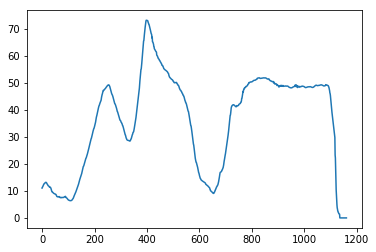

In [10]:
df.enhanced_speed.plot()

In order to merge this table with the one from the car in front, we need matching `timestamp_ms`.  
Since they don't match, we bin and sort them:

In [11]:
bins = [n * 100 for n in range(11)]
labels = list(range(10))
print('bins ->', bins)
print('labels ->', labels)

bins -> [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
labels -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [12]:
df['ms_bin'] = pd.cut(df.timestamp_ms, bins, right=False, labels=labels)
df = df.sort_values(['utc_timestamp', 'ms_bin']).drop_duplicates(['utc_timestamp', 'ms_bin'])
df.head(15)

,utc_timestamp,timestamp_ms,position_lat,position_long,enhanced_altitude,enhanced_speed,velocity,ms_bin
7,2019-07-01 14:45:39+00:00,40,57.786767,12.770016,178.8,12.5604,"(-1.26, 3.25, 0.01)",0
8,2019-07-01 14:45:39+00:00,140,57.786769,12.770013,178.8,12.6108,"(-1.24, 3.27, 0.02)",1
9,2019-07-01 14:45:39+00:00,240,57.786772,12.770007,178.8,12.7152,"(-1.24, 3.3, 0.02)",2
0,2019-07-01 14:45:39+00:00,340,57.786787,12.770023,178.8,11.0556,"(-0.87, 2.94, 0.0)",3
1,2019-07-01 14:45:39+00:00,440,57.786787,12.770024,178.8,11.3256,"(-1.0, 2.98, 0.0)",4
2,2019-07-01 14:45:39+00:00,540,57.786783,12.770022,178.8,11.4408,"(-1.09, 2.98, 0.0)",5
3,2019-07-01 14:45:39+00:00,640,57.786775,12.770018,178.8,11.6280,"(-1.14, 3.02, 0.01)",6
4,2019-07-01 14:45:39+00:00,740,57.786772,12.770013,178.8,11.8332,"(-1.18, 3.06, 0.01)",7
5,2019-07-01 14:45:39+00:00,840,57.786770,12.770014,178.8,12.0780,"(-1.21, 3.12, 0.01)",8
6,2019-07-01 14:45:39+00:00,940,57.786767,12.770018,178.8,12.3444,"(-1.23, 3.19, 0.01)",9


Note that we dropped duplicates. This is because in some case we had two measurements in the same `ms_bin`.

### For the car on the front

In [13]:
!rm ./data/front/2026-01-01-08-42-56.csv

In [14]:
parse_fitfiles(path='./data/front/')

Converting 2026-01-01-08-42-56.fit...
Wrote ./data/front/2026-01-01-08-42-56.csv
Finished conversions!


In [15]:
df_f = pd.read_csv('./data/front/2026-01-01-08-42-56.csv')

In [16]:
df_f.head(20)

,utc_timestamp,timestamp_ms,position_lat,position_long,enhanced_altitude,enhanced_speed,velocity
0,2019-07-01 13:50:41+00:00,981,57.786612,12.769824,193.4,0.0,"(0.0, 0.16, -0.54)"
1,2019-07-01 13:50:41+00:00,81,57.786612,12.769825,193.4,0.0,"(0.0, 0.16, -0.53)"
2,2019-07-01 13:50:41+00:00,181,57.786611,12.769825,193.4,0.0,"(0.0, 0.16, -0.52)"
3,2019-07-01 13:50:41+00:00,281,57.786611,12.769825,193.4,0.0,"(0.0, 0.15, -0.51)"
4,2019-07-01 13:50:41+00:00,381,57.786610,12.769826,193.6,0.0,"(0.0, 0.15, -0.5)"
5,2019-07-01 13:50:41+00:00,481,57.786610,12.769826,193.6,0.0,"(0.0, 0.15, -0.49)"
6,2019-07-01 13:50:41+00:00,581,57.786609,12.769825,193.4,0.0,"(0.0, 0.15, -0.47)"
7,2019-07-01 13:50:41+00:00,681,57.786608,12.769825,193.4,0.0,"(0.0, 0.14, -0.46)"
8,2019-07-01 13:50:41+00:00,781,57.786608,12.769825,193.4,0.0,"(0.0, 0.13, -0.46)"
9,2019-07-01 13:50:41+00:00,881,57.786607,12.769824,193.4,0.0,"(0.0, 0.12, -0.45)"


In [17]:
df_f.shape

(40644, 7)

In [18]:
df_f.utc_timestamp.min(), df_f.utc_timestamp.max()

('2019-07-01 13:50:41+00:00', '2019-07-01 14:58:25+00:00')

In [19]:
df_f.groupby('utc_timestamp').size().value_counts()

10    4064
4        1
dtype: int64

Same as before, we bin and sort them:

In [20]:
df_f['ms_bin'] = pd.cut(df_f.timestamp_ms, bins, right=False, labels=labels)
df_f = df_f.sort_values(['utc_timestamp', 'ms_bin']).drop_duplicates(['utc_timestamp', 'ms_bin'])
df_f.head(15)

,utc_timestamp,timestamp_ms,position_lat,position_long,enhanced_altitude,enhanced_speed,velocity,ms_bin
1,2019-07-01 13:50:41+00:00,81,57.786612,12.769825,193.4,0.0,"(0.0, 0.16, -0.53)",0
2,2019-07-01 13:50:41+00:00,181,57.786611,12.769825,193.4,0.0,"(0.0, 0.16, -0.52)",1
3,2019-07-01 13:50:41+00:00,281,57.786611,12.769825,193.4,0.0,"(0.0, 0.15, -0.51)",2
4,2019-07-01 13:50:41+00:00,381,57.786610,12.769826,193.6,0.0,"(0.0, 0.15, -0.5)",3
5,2019-07-01 13:50:41+00:00,481,57.786610,12.769826,193.6,0.0,"(0.0, 0.15, -0.49)",4
6,2019-07-01 13:50:41+00:00,581,57.786609,12.769825,193.4,0.0,"(0.0, 0.15, -0.47)",5
7,2019-07-01 13:50:41+00:00,681,57.786608,12.769825,193.4,0.0,"(0.0, 0.14, -0.46)",6
8,2019-07-01 13:50:41+00:00,781,57.786608,12.769825,193.4,0.0,"(0.0, 0.13, -0.46)",7
9,2019-07-01 13:50:41+00:00,881,57.786607,12.769824,193.4,0.0,"(0.0, 0.12, -0.45)",8
0,2019-07-01 13:50:41+00:00,981,57.786612,12.769824,193.4,0.0,"(0.0, 0.16, -0.54)",9


## Merging the two tables

Now we are going to merge both tables: the one with data from the car on the back and the one in the front:

In [22]:
df_m = pd.merge(df, df_f, on=['utc_timestamp', 'ms_bin'],
                how='left', suffixes=['_b', '_f'])
df_m.shape

(1160, 14)

Note that we `left`-merged. This is because the data from the car in the front contains a longer timespan with data we don't really need.

In [23]:
df_m.head()

,utc_timestamp,timestamp_ms_b,position_lat_b,position_long_b,enhanced_altitude_b,enhanced_speed_b,velocity_b,ms_bin,timestamp_ms_f,position_lat_f,position_long_f,enhanced_altitude_f,enhanced_speed_f,velocity_f
0,2019-07-01 14:45:39+00:00,40,57.786767,12.770016,178.8,12.5604,"(-1.26, 3.25, 0.01)",0,44,57.782659,12.775736,186.6,0.0,"(0.0, 0.01, 0.05)"
1,2019-07-01 14:45:39+00:00,140,57.786769,12.770013,178.8,12.6108,"(-1.24, 3.27, 0.02)",1,144,57.782659,12.775735,186.4,0.0,"(0.0, 0.01, 0.04)"
2,2019-07-01 14:45:39+00:00,240,57.786772,12.770007,178.8,12.7152,"(-1.24, 3.3, 0.02)",2,244,57.782659,12.775735,186.4,0.0,"(0.0, 0.01, 0.05)"
3,2019-07-01 14:45:39+00:00,340,57.786787,12.770023,178.8,11.0556,"(-0.87, 2.94, 0.0)",3,344,57.782659,12.775734,186.4,0.0,"(0.0, 0.01, 0.04)"
4,2019-07-01 14:45:39+00:00,440,57.786787,12.770024,178.8,11.3256,"(-1.0, 2.98, 0.0)",4,444,57.782660,12.775734,186.4,0.0,"(0.0, 0.0, 0.04)"


## Computing the distance with the Haversine formula

The [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) determines the great-circle distance between two points on a sphere given their longitudes and latitudes.
Reference:
- https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas/29546836#29546836
- https://stackoverflow.com/questions/43981199/how-to-group-by-trip-id-and-find-the-straight-distance-traveled

In [24]:
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians).

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.
    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [26]:
df_m['dist'] = haversine(df_m.position_long_b, df_m.position_lat_b,
                         df_m.position_long_f, df_m.position_lat_f)
# Change km to m
df_m['dist'] *= 1000
df_m.head(10)

,utc_timestamp,timestamp_ms_b,position_lat_b,position_long_b,enhanced_altitude_b,enhanced_speed_b,velocity_b,ms_bin,timestamp_ms_f,position_lat_f,position_long_f,enhanced_altitude_f,enhanced_speed_f,velocity_f,dist
0,2019-07-01 14:45:39+00:00,40,57.786767,12.770016,178.8,12.5604,"(-1.26, 3.25, 0.01)",0,44,57.782659,12.775736,186.6,0.0,"(0.0, 0.01, 0.05)",776.538188
1,2019-07-01 14:45:39+00:00,140,57.786769,12.770013,178.8,12.6108,"(-1.24, 3.27, 0.02)",1,144,57.782659,12.775735,186.4,0.0,"(0.0, 0.01, 0.04)",776.859785
2,2019-07-01 14:45:39+00:00,240,57.786772,12.770007,178.8,12.7152,"(-1.24, 3.3, 0.02)",2,244,57.782659,12.775735,186.4,0.0,"(0.0, 0.01, 0.05)",777.523235
3,2019-07-01 14:45:39+00:00,340,57.786787,12.770023,178.8,11.0556,"(-0.87, 2.94, 0.0)",3,344,57.782659,12.775734,186.4,0.0,"(0.0, 0.01, 0.04)",776.944542
4,2019-07-01 14:45:39+00:00,440,57.786787,12.770024,178.8,11.3256,"(-1.0, 2.98, 0.0)",4,444,57.782660,12.775734,186.4,0.0,"(0.0, 0.0, 0.04)",776.745525
5,2019-07-01 14:45:39+00:00,540,57.786783,12.770022,178.8,11.4408,"(-1.09, 2.98, 0.0)",5,544,57.782660,12.775733,186.4,0.0,"(0.0, 0.01, 0.04)",776.639931
6,2019-07-01 14:45:39+00:00,640,57.786775,12.770018,178.8,11.6280,"(-1.14, 3.02, 0.01)",6,644,57.782660,12.775733,186.2,0.0,"(0.0, 0.01, 0.03)",776.505903
7,2019-07-01 14:45:39+00:00,740,57.786772,12.770013,178.8,11.8332,"(-1.18, 3.06, 0.01)",7,744,57.782660,12.775733,186.2,0.0,"(0.0, 0.0, 0.0)",776.737961
8,2019-07-01 14:45:39+00:00,840,57.786770,12.770014,178.8,12.0780,"(-1.21, 3.12, 0.01)",8,844,57.782660,12.775733,186.2,0.0,"(0.0, 0.0, 0.0)",776.574574
9,2019-07-01 14:45:39+00:00,940,57.786767,12.770018,178.8,12.3444,"(-1.23, 3.19, 0.01)",9,944,57.782658,12.775736,186.6,0.0,"(0.0, 0.01, 0.05)",776.345315


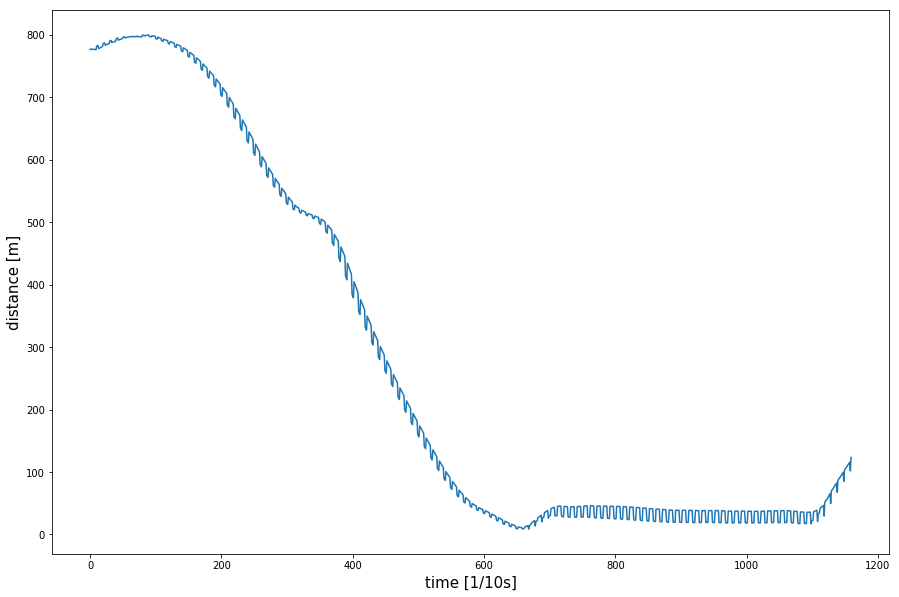

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.set_xlabel(xlabel='time [1/10s]', fontsize=15)
ax.set_ylabel(ylabel='distance [m]', fontsize=15)
ax.plot(df_m.dist.index, df_m.dist)
plt.show()

Weird... The values make sense, but the steps don't. Taking a closer look to the time windonw when the cars are close by:

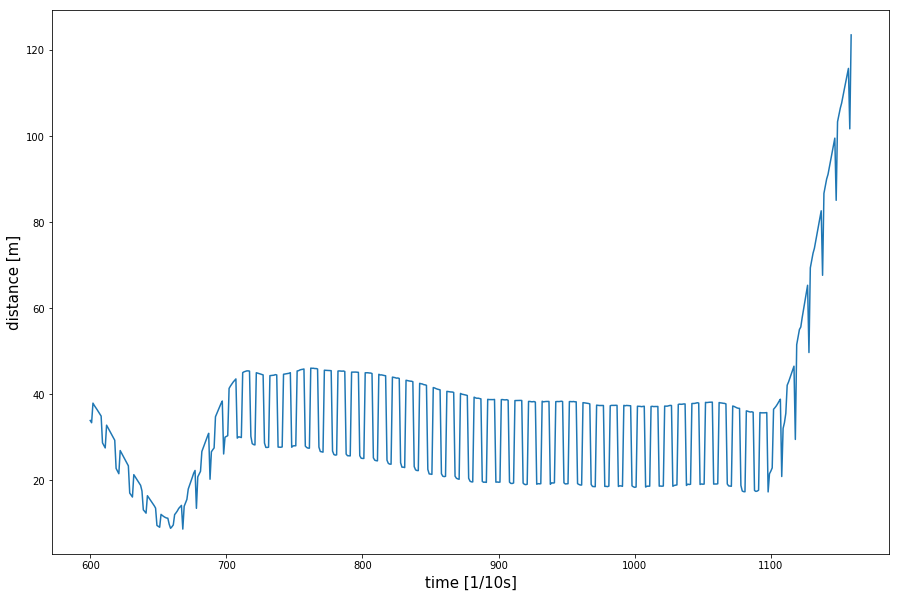

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.set_xlabel(xlabel='time [1/10s]', fontsize=15)
ax.set_ylabel(ylabel='distance [m]', fontsize=15)
ax.plot(df_m.iloc[600::, -1].index, df_m.iloc[600::, -1])
plt.show()

In [30]:
df_m.dist.min(), df_m.dist.max()

(8.632575703633282, 799.8943116497769)

## Computing the distance using ENU coordinates

In many targeting and tracking applications the local East, North, Up (ENU) Cartesian coordinate system is far more intuitive and practical than ECEF or Geodetic coordinates.

We will make use of a script (`geofun.py`) to convert GPS coordinates to ENU ones.

Reference:
- https://en.wikipedia.org/wiki/Local_tangent_plane_coordinates
- https://en.wikipedia.org/wiki/Geographic_coordinate_system#Local_tangent_plane

In [31]:
import sys
sys.path.append('./scripts/')
import geofun as g
#import importlib
#importlib.reload(g)

In [40]:
lat_b = 'position_lat_b'
lon_b = 'position_long_b'
alt_b = 'enhanced_altitude_b'

lat_f = 'position_lat_f'
lon_f = 'position_long_f'
alt_f = 'enhanced_altitude_f'


# Convert to radians
df_m['pos_lat_b_rad'], df_m['pos_lon_b_rad'], df_m['alt_b_m'] = df_m[lat_b] / 180 * np.pi, \
                                                                df_m[lon_b] / 180 * np.pi, \
                                                                df_m[alt_b] / 180 * np.pi

df_m['pos_lat_f_rad'], df_m['pos_lon_f_rad'], df_m['alt_f_m'] = df_m[lat_f] / 180 * np.pi, \
                                                                df_m[lon_f] / 180 * np.pi, \
                                                                df_m[alt_f] / 180 * np.pi

# For the first, find center and calculate ENU
center = [df_m['pos_lat_b_rad'].mean(), 
          df_m['pos_lon_b_rad'].mean(), 
          df_m['alt_b_m'].mean()]

df_m['E_b'], df_m['N_b'], df_m['U_b'] = g.geo2enu(df_m['pos_lat_b_rad'], 
                                                  df_m['pos_lon_b_rad'],
                                                  df_m['alt_b_m'], *center)

df_m['E_f'], df_m['N_f'], df_m['U_f'] = g.geo2enu(df_m['pos_lat_f_rad'], 
                                                  df_m['pos_lon_f_rad'],
                                                  df_m['alt_f_m'], *center)
print(center)
df_m.head()

[1.0085368305077338, 0.2229217288342903, 3.224778656765882]


,utc_timestamp,timestamp_ms_b,position_lat_b,position_long_b,enhanced_altitude_b,enhanced_speed_b,velocity_b,ms_bin,timestamp_ms_f,position_lat_f,...,alt_b_m,pos_lat_f_rad,pos_lon_f_rad,alt_f_m,E_b,N_b,U_b,E_f,N_f,U_f
0,2019-07-01 14:45:39+00:00,40,57.786767,12.770016,178.8,12.5604,"(-1.26, 3.25, 0.01)",0,44,57.782659,...,3.120649,1.008498,0.222979,3.256784,-146.251153,207.464910,-0.109175,194.023043,-250.063140,0.024162
1,2019-07-01 14:45:39+00:00,140,57.786769,12.770013,178.8,12.6108,"(-1.24, 3.27, 0.02)",1,144,57.782659,...,3.120649,1.008498,0.222979,3.253294,-146.395733,207.754308,-0.109188,193.993123,-250.035136,0.020673
2,2019-07-01 14:45:39+00:00,240,57.786772,12.770007,178.8,12.7152,"(-1.24, 3.3, 0.02)",2,244,57.782659,...,3.120649,1.008498,0.222979,3.253294,-146.739747,208.099725,-0.109207,193.963204,-250.016467,0.020675
3,2019-07-01 14:45:39+00:00,340,57.786787,12.770023,178.8,11.0556,"(-0.87, 2.94, 0.0)",3,344,57.782659,...,3.120649,1.008498,0.222979,3.253294,-145.822285,209.714691,-0.109239,193.928296,-249.969792,0.020678
4,2019-07-01 14:45:39+00:00,440,57.786787,12.770024,178.8,11.3256,"(-1.0, 2.98, 0.0)",4,444,57.782660,...,3.120649,1.008498,0.222979,3.253294,-145.742512,209.686682,-0.109236,193.898376,-249.941788,0.020680


Compute (Euclidean) distance:

In [41]:
df_m['dist_enu'] = np.sqrt((df_m.E_b - df_m.E_f)**2 + \
                           (df_m.N_b - df_m.N_f)**2 + \
                           (df_m.U_b - df_m.U_f)**2)
df_m.dist_enu.head()

0    570.191602
1    570.469776
2    570.919402
3    571.612017
4    571.501776
Name: dist_enu, dtype: float64

Now we can compare both distances (Haversine and ENU):

[]

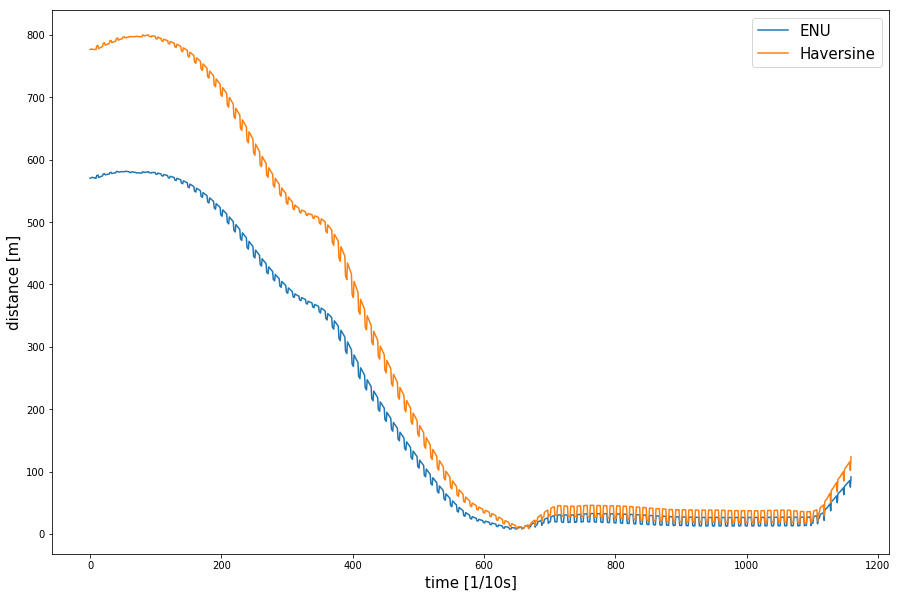

In [44]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(df_m.iloc[:, -1].index, df_m.iloc[:, -1])
ax.plot(df_m.loc[:, 'dist'].index, df_m.loc[:, 'dist'])
ax.legend(['ENU', 'Haversine'], fontsize=15)
ax.set_xlabel(xlabel='time [1/10s]', fontsize=15)
ax.set_ylabel(ylabel='distance [m]', fontsize=15)
plt.plot()

[]

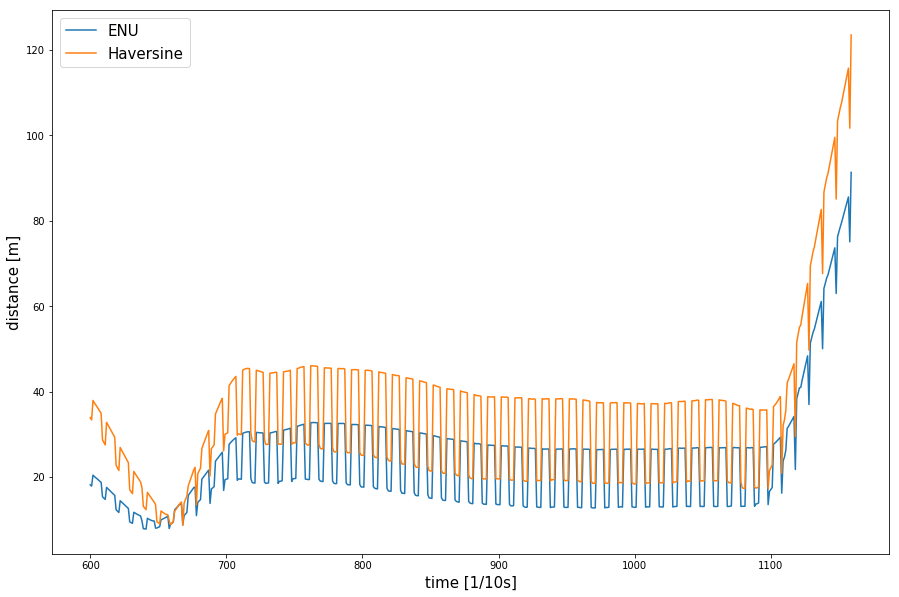

In [45]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(df_m.iloc[600:, -1].index, df_m.iloc[600:, -1])
ax.plot(df_m.loc[600:, 'dist'].index, df_m.loc[600:, 'dist'])
ax.legend(['ENU', 'Haversine'], fontsize=15)
ax.set_xlabel(xlabel='time [1/10s]', fontsize=15)
ax.set_ylabel(ylabel='distance [m]', fontsize=15)
plt.plot()

It seems like we are on the right track, although we still obtain the steps in the distance plot.  
If we examine the original GPS coordinates, it seems like "sometimes" the car takes a step back, producing this phenomenon.  

We can notice that there is a sort of seasonality in the distance values. After playing around a bit, it seems like the first two and last two values of every second are producing this:

[]

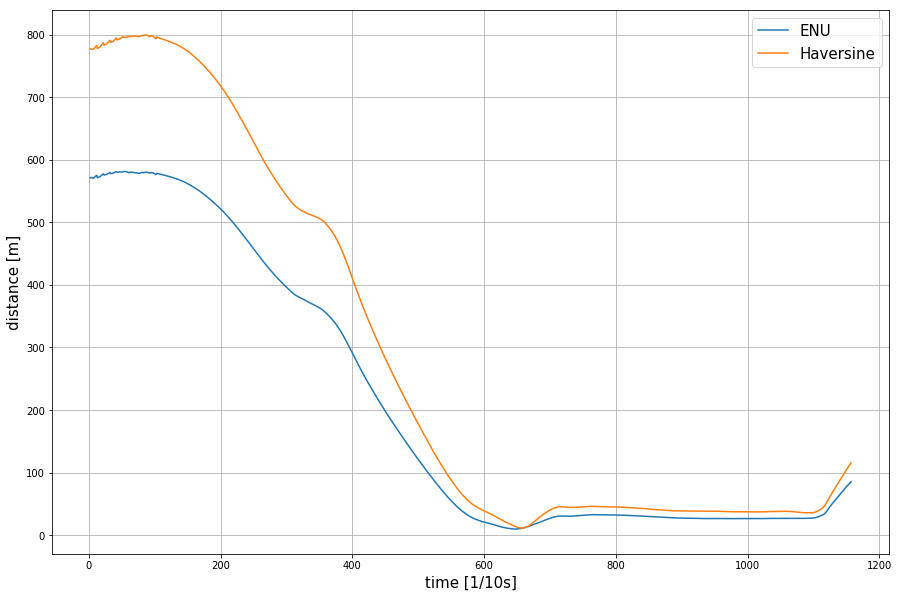

In [50]:
idx = [i for i in range(df_m.shape[0]) if i%10 not in [0, 1, 8, 9]]

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(df_m.iloc[idx, -1].index, df_m.iloc[idx, -1])
ax.plot(df_m.loc[idx, 'dist'].index, df_m.loc[idx, 'dist'])
ax.legend(['ENU', 'Haversine'], fontsize=15)
ax.set_xlabel(xlabel='time [1/10s]', fontsize=15)
ax.set_ylabel(ylabel='distance [m]', fontsize=15)
plt.grid()
plt.plot()

[]

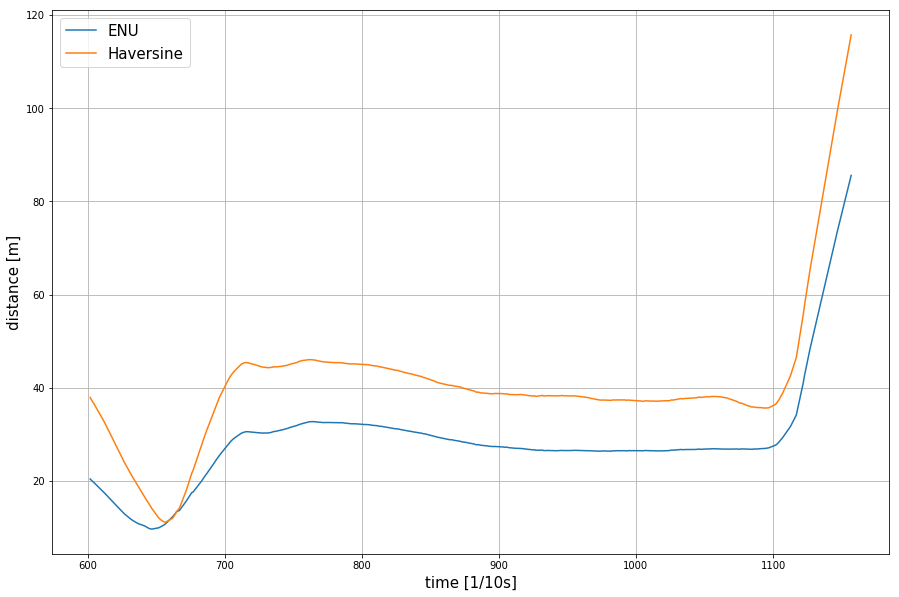

In [51]:
idx = [i for i in range(600, df_m.shape[0]) if i%10 not in [0, 1, 8, 9]]

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(df_m.iloc[idx, -1].index, df_m.iloc[idx, -1])
ax.plot(df_m.loc[idx, 'dist'].index, df_m.loc[idx, 'dist'])
#ax.plot(641, aux.iloc[641, -1], 'ro')
ax.legend(['ENU', 'Haversine'], fontsize=15)
ax.set_xlabel(xlabel='time [1/10s]', fontsize=15)
ax.set_ylabel(ylabel='distance [m]', fontsize=15)
plt.grid()
plt.plot()

That looks waaaaaay smoother!

## Evaluating the two methods

Now a fair question we may make is: **which of the two distances is more accurate?**  
Google Maps includes a really helpful tool to measure distances over the map. 

If we trust it, the initial distance should be:
![./graphs/long-distance.png](./graphs/long-distance.png)

That snapshot was taken using the initial GPS positions of both cars. If we check our two candidate distances:

In [61]:
df_m.iloc[0, [14, -1]]

dist        776.538
dist_enu    570.192
Name: 0, dtype: object

Looks like the ENU system beats Haversine (by far). But what about on the short distances? In the previous distance plot they looked close...

![./graphs/short-distance.png](./graphs/short-distance.png)

In [58]:
df_m.loc[df_m.dist_enu == df_m.dist_enu.min(), ['dist', 'dist_enu']]

,dist,dist_enu
641,12.336288,7.788899


The ENU distance (practically) matches the one obtained from Google Maps distance calculator.  
Just to give an idea, we have checked the distances corresponding to the following timestamps:

[]

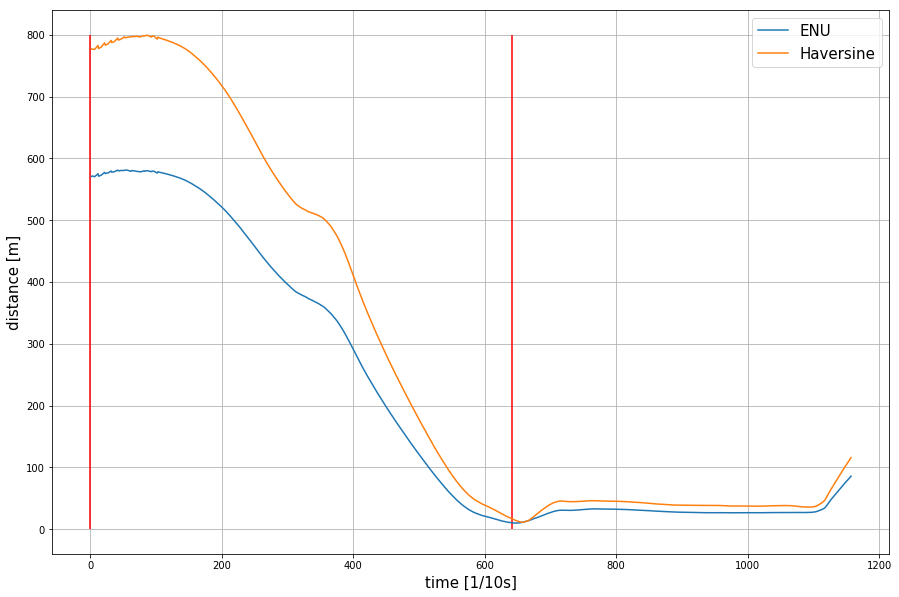

In [68]:
idx = [i for i in range(df_m.shape[0]) if i%10 not in [0, 1, 8, 9]]


fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(df_m.iloc[idx, -1].index, df_m.iloc[idx, -1])
ax.plot(df_m.loc[idx, 'dist'].index, df_m.loc[idx, 'dist'])
ax.axes.vlines([641, 0], ymin=0, ymax=800, colors='r')
ax.legend(['ENU', 'Haversine'], fontsize=15)
ax.set_xlabel(xlabel='time [1/10s]', fontsize=15)
ax.set_ylabel(ylabel='distance [m]', fontsize=15)
plt.grid()
plt.plot()

## Save the obtained data

In [46]:
df_m.to_csv('./data/gps-distances.csv', index=False)
#df_m = pd.read_csv('./data/gps-distances.csv')

# U-blox

## Loading the data

In [116]:
df_u = pd.read_csv('./data/ublox-sample.csv')
df_u.shape

(4000, 26)

In [117]:
df_u.head()

,Time(s),Velocity(m/s) A8 ubx,metric A8 ubx,E A8 ubx,N A8 ubx,U A8 ubx,Velocity(m/s) Tesla ubx,metric Tesla ubx,E Tesla ubx,N Tesla ubx,...,Velocity(m/s) A6 ubx,metric A6 ubx,E A6 ubx,N A6 ubx,U A6 ubx,Velocity(m/s) Mercedes ubx,metric Mercedes ubx,E Mercedes ubx,N Mercedes ubx,U Mercedes ubx
0,47854.4,16.687907,0.575000,172.255516,644.424084,0.495869,16.219197,0.50,194.893809,608.952057,...,17.261000,0.350000,250.079206,528.535499,0.650736,16.663000,0.6,266.968905,501.305651,0.589104
1,47854.5,16.685083,0.583333,171.357216,645.810393,0.495596,16.234975,0.55,193.990942,610.302834,...,17.258226,0.333333,249.145014,529.948874,0.649851,16.681336,0.6,266.044178,502.696976,0.588250
2,47854.6,16.681516,0.591667,170.458936,647.196127,0.495332,16.249757,0.60,193.088117,611.654068,...,17.251618,0.316667,248.207680,531.358264,0.648885,16.698699,0.6,265.117714,504.090229,0.587398
3,47854.7,16.677000,0.600000,169.560701,648.581268,0.495087,16.263877,0.60,192.185779,613.005608,...,17.239000,0.300000,247.265288,532.767535,0.647910,16.715268,0.6,264.189812,505.484759,0.586558
4,47854.8,16.671455,0.591667,168.662525,649.965800,0.494868,16.277227,0.60,191.283556,614.357438,...,17.219517,0.300000,246.317146,534.179715,0.646978,16.731221,0.6,263.260775,506.879910,0.585737


In [118]:
df_u.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 26 columns):
Time(s)                       4000 non-null float64
Velocity(m/s) A8 ubx          4000 non-null float64
metric A8 ubx                 4000 non-null float64
E A8 ubx                      4000 non-null float64
N A8 ubx                      4000 non-null float64
U A8 ubx                      4000 non-null float64
Velocity(m/s) Tesla ubx       4000 non-null float64
metric Tesla ubx              4000 non-null float64
E Tesla ubx                   4000 non-null float64
N Tesla ubx                   4000 non-null float64
U Tesla ubx                   4000 non-null float64
Velocity(m/s) BMW ubx         4000 non-null float64
metric BMW ubx                4000 non-null float64
E BMW ubx                     4000 non-null float64
N BMW ubx                     4000 non-null float64
U BMW ubx                     4000 non-null float64
Velocity(m/s) A6 ubx          4000 non-null float64
metric A6

## Computing the distance with ENU coordinates

The columns are in order for this experiment, so the platoon was:
1. A8,
2. Tesla,
3. BMW,
4. A6, and
5. Mercedes.

Lets compute the distance from the Mercedes to all other cars:

In [124]:
df_u['dist_merc_a6'] = np.sqrt((df_u['E Mercedes ubx'] - df_u['E A6 ubx'])**2 + \
                               (df_u['N Mercedes ubx'] - df_u['N A6 ubx'])**2 + \
                               (df_u['U Mercedes ubx'] - df_u['U A6 ubx'])**2)

df_u['dist_merc_bmw'] = np.sqrt((df_u['E Mercedes ubx'] - df_u['E BMW ubx'])**2 + \
                                (df_u['N Mercedes ubx'] - df_u['N BMW ubx'])**2 + \
                                (df_u['U Mercedes ubx'] - df_u['U BMW ubx'])**2)

df_u['dist_merc_tesla'] = np.sqrt((df_u['E Mercedes ubx'] - df_u['E Tesla ubx'])**2 + \
                                  (df_u['N Mercedes ubx'] - df_u['N Tesla ubx'])**2 + \
                                  (df_u['U Mercedes ubx'] - df_u['U Tesla ubx'])**2)

df_u['dist_merc_a8'] = np.sqrt((df_u['E Mercedes ubx'] - df_u['E A8 ubx'])**2 + \
                               (df_u['N Mercedes ubx'] - df_u['N A8 ubx'])**2 + \
                               (df_u['U Mercedes ubx'] - df_u['U A8 ubx'])**2)

df_u.iloc[0:10, -4:]

,dist_merc_a6,dist_merc_bmw,dist_merc_tesla,dist_merc_a8
0,32.042633,81.852071,129.607542,171.620280
1,32.066361,81.892852,129.561687,171.601514
2,32.085803,81.935223,129.513619,171.579691
3,32.105968,81.978312,129.463675,171.555496
4,32.130509,82.021279,129.412761,171.529615
5,32.157660,82.063407,129.361920,171.502758
6,32.184295,82.104007,129.312198,171.475637
7,32.208005,82.142582,129.264384,171.448711
8,32.229251,82.179401,129.218246,171.421415
9,32.249211,82.214921,129.173298,171.392930


## Some plots

[]

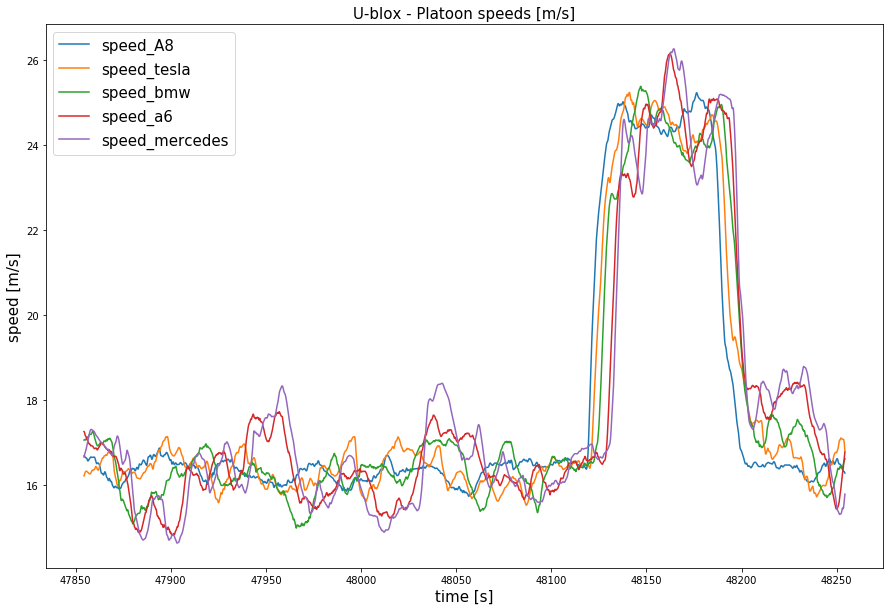

In [151]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(df_u.loc[:, 'Time(s)'], df_u.loc[:, 'Velocity(m/s) A8 ubx'])
ax.plot(df_u.loc[:, 'Time(s)'], df_u.loc[:, 'Velocity(m/s) Tesla ubx'])
ax.plot(df_u.loc[:, 'Time(s)'], df_u.loc[:, 'Velocity(m/s) BMW ubx'])
ax.plot(df_u.loc[:, 'Time(s)'], df_u.loc[:, 'Velocity(m/s) A6 ubx'])
ax.plot(df_u.loc[:, 'Time(s)'], df_u.loc[:, 'Velocity(m/s) Mercedes ubx'])
ax.legend(['speed_A8', 'speed_tesla', 'speed_bmw', 'speed_a6', 'speed_mercedes'], fontsize=15)
ax.set_xlabel(xlabel='time [s]', fontsize=15)
ax.set_ylabel(ylabel='speed [m/s]', fontsize=15)
ax.set_title('U-blox - Platoon speeds [m/s]', fontsize=15) 
plt.plot()

[]

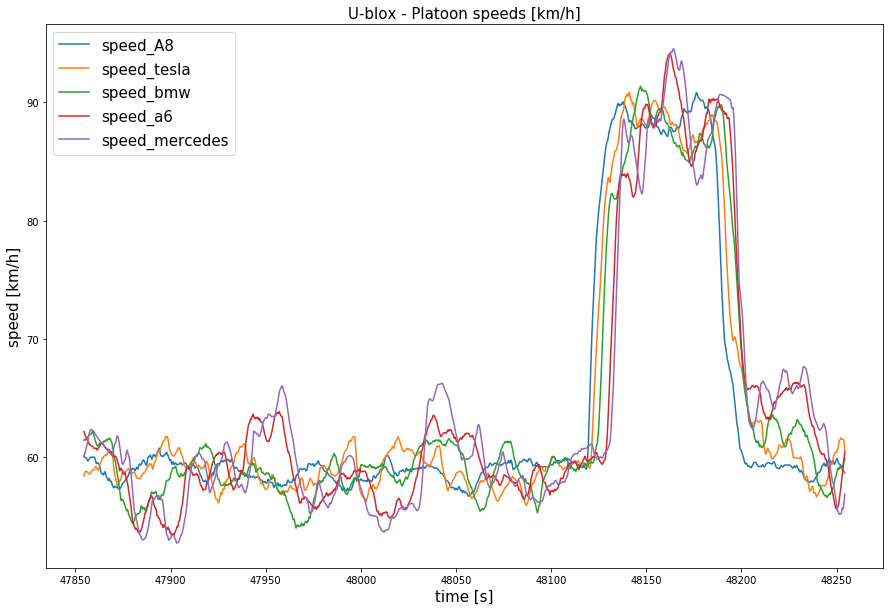

In [152]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(df_u.loc[:, 'Time(s)'], df_u.loc[:, 'Velocity(m/s) A8 ubx'] / 1000 * 3600)
ax.plot(df_u.loc[:, 'Time(s)'], df_u.loc[:, 'Velocity(m/s) Tesla ubx'] / 1000 * 3600)
ax.plot(df_u.loc[:, 'Time(s)'], df_u.loc[:, 'Velocity(m/s) BMW ubx'] / 1000 * 3600)
ax.plot(df_u.loc[:, 'Time(s)'], df_u.loc[:, 'Velocity(m/s) A6 ubx'] / 1000 * 3600)
ax.plot(df_u.loc[:, 'Time(s)'], df_u.loc[:, 'Velocity(m/s) Mercedes ubx'] / 1000 * 3600)
ax.legend(['speed_A8', 'speed_tesla', 'speed_bmw', 'speed_a6', 'speed_mercedes'], fontsize=15)
ax.set_xlabel(xlabel='time [s]', fontsize=15)
ax.set_ylabel(ylabel='speed [km/h]', fontsize=15)
ax.set_title('U-blox - Platoon speeds [km/h]', fontsize=15) 
plt.plot()

[]

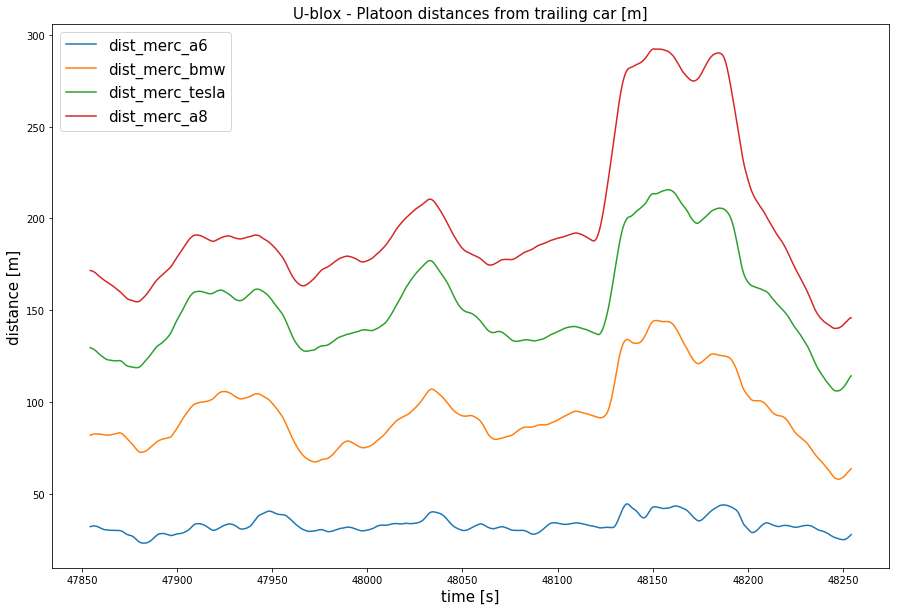

In [156]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(df_u.loc[:, 'Time(s)'], df_u.loc[:, 'dist_merc_a6'])
ax.plot(df_u.loc[:, 'Time(s)'], df_u.loc[:, 'dist_merc_bmw'])
ax.plot(df_u.loc[:, 'Time(s)'], df_u.loc[:, 'dist_merc_tesla'])
ax.plot(df_u.loc[:, 'Time(s)'], df_u.loc[:, 'dist_merc_a8'])
ax.legend(['dist_merc_a6', 'dist_merc_bmw', 'dist_merc_tesla', 'dist_merc_a8'], fontsize=15)
ax.set_xlabel(xlabel='time [s]', fontsize=15)
ax.set_ylabel(ylabel='distance [m]', fontsize=15)
ax.set_title('U-blox - Platoon distances from trailing car [m]', fontsize=15) 
plt.plot()

Checking a smaller range:

[]

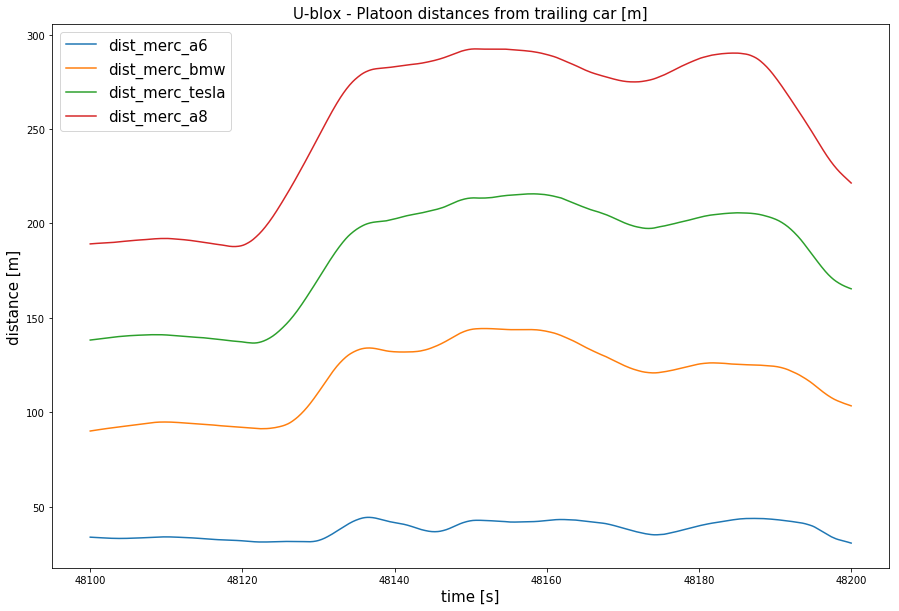

In [157]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(df_u.loc[2456:3456, 'Time(s)'], df_u.loc[2456:3456, 'dist_merc_a6'])
ax.plot(df_u.loc[2456:3456, 'Time(s)'], df_u.loc[2456:3456, 'dist_merc_bmw'])
ax.plot(df_u.loc[2456:3456, 'Time(s)'], df_u.loc[2456:3456, 'dist_merc_tesla'])
ax.plot(df_u.loc[2456:3456, 'Time(s)'], df_u.loc[2456:3456, 'dist_merc_a8'])
ax.legend(['dist_merc_a6', 'dist_merc_bmw', 'dist_merc_tesla', 'dist_merc_a8'], fontsize=15)
ax.set_xlabel(xlabel='time [s]', fontsize=15)
ax.set_ylabel(ylabel='distance [m]', fontsize=15)
ax.set_title('U-blox - Platoon distances from trailing car [m]', fontsize=15) 
plt.plot()

# Differential GPS

## Loading the data

In [2]:
df_d = pd.read_csv('./data/dgps-sample.csv')
df_d.shape

(4000, 26)

In [3]:
df_d.head()

,Time(s),Velocity(m/s) A8 azd,metric A8 azd,E A8 azd,N A8 azd,U A8 azd,Velocity(m/s) Tesla azd,metric Tesla azd,E Tesla azd,N Tesla azd,...,Velocity(m/s) A6 azd,metric A6 azd,E A6 azd,N A6 azd,U A6 azd,Velocity(m/s) Mercedes azd,metric Mercedes azd,E Mercedes azd,N Mercedes azd,U Mercedes azd
0,47854.4,16.366364,0.1,171.553402,645.625626,-0.145505,16.225455,0.1,194.862439,609.951490,...,17.113636,0.1,248.419479,529.482017,-0.050166,16.610000,0.1,266.688575,502.396238,-0.030837
1,47854.5,16.360000,0.1,170.647319,646.988849,-0.146762,16.241111,0.1,193.962649,611.300871,...,17.107778,0.1,247.474169,530.908040,-0.051087,16.628889,0.1,265.771003,503.782355,-0.031593
2,47854.6,16.357273,0.1,169.740172,648.351679,-0.148024,16.264545,0.1,193.062156,612.651613,...,17.099091,0.1,246.530536,532.334086,-0.052042,16.648182,0.1,264.851959,505.169733,-0.032380
3,47854.7,16.352222,0.1,168.833483,649.714835,-0.149274,16.280000,0.1,192.160216,614.004201,...,17.086667,0.1,245.588376,533.759716,-0.053027,16.665556,0.1,263.931720,506.558662,-0.033121
4,47854.8,16.351818,0.1,167.927107,651.077834,-0.150508,16.294545,0.1,191.257496,615.358116,...,17.074545,0.1,244.646842,535.184637,-0.054025,16.687273,0.1,263.009343,507.948391,-0.033840


In [4]:
df_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 26 columns):
Time(s)                       4000 non-null float64
Velocity(m/s) A8 azd          4000 non-null float64
metric A8 azd                 4000 non-null float64
E A8 azd                      4000 non-null float64
N A8 azd                      4000 non-null float64
U A8 azd                      4000 non-null float64
Velocity(m/s) Tesla azd       4000 non-null float64
metric Tesla azd              4000 non-null float64
E Tesla azd                   4000 non-null float64
N Tesla azd                   4000 non-null float64
U Tesla azd                   4000 non-null float64
Velocity(m/s) BMW azd         4000 non-null float64
metric BMW azd                4000 non-null float64
E BMW azd                     4000 non-null float64
N BMW azd                     4000 non-null float64
U BMW azd                     4000 non-null float64
Velocity(m/s) A6 azd          4000 non-null float64
metric A6

## Computing the distance with ENU coordinates

The columns are in order for this experiment, so the platoon was:
1. A8,
2. Tesla,
3. BMW,
4. A6, and
5. Mercedes.

Lets compute the distance from the Mercedes to all other cars:

In [5]:
df_d['dist_merc_a6'] = np.sqrt((df_d['E Mercedes azd'] - df_d['E A6 azd'])**2 + \
                               (df_d['N Mercedes azd'] - df_d['N A6 azd'])**2 + \
                               (df_d['U Mercedes azd'] - df_d['U A6 azd'])**2)

df_d['dist_merc_bmw'] = np.sqrt((df_d['E Mercedes azd'] - df_d['E BMW azd'])**2 + \
                                (df_d['N Mercedes azd'] - df_d['N BMW azd'])**2 + \
                                (df_d['U Mercedes azd'] - df_d['U BMW azd'])**2)

df_d['dist_merc_tesla'] = np.sqrt((df_d['E Mercedes azd'] - df_d['E Tesla azd'])**2 + \
                                  (df_d['N Mercedes azd'] - df_d['N Tesla azd'])**2 + \
                                  (df_d['U Mercedes azd'] - df_d['U Tesla azd'])**2)

df_d['dist_merc_a8'] = np.sqrt((df_d['E Mercedes azd'] - df_d['E A8 azd'])**2 + \
                               (df_d['N Mercedes azd'] - df_d['N A8 azd'])**2 + \
                               (df_d['U Mercedes azd'] - df_d['U A8 azd'])**2)

df_d.iloc[0:10, -4:]

,dist_merc_a6,dist_merc_bmw,dist_merc_tesla,dist_merc_a8
0,32.671083,80.324624,129.333415,171.945839
1,32.719677,80.360093,129.292989,171.920413
2,32.765485,80.394373,129.252222,171.893383
3,32.808169,80.427136,129.211837,171.864418
4,32.848058,80.458626,129.171139,171.833300
5,32.884812,80.488578,129.130534,171.800407
6,32.918531,80.517358,129.089102,171.765746
7,32.949362,80.544780,129.047659,171.729264
8,32.977018,80.571071,129.004814,171.690886
9,33.001399,80.594591,128.960202,171.649350


## Some plots

[]

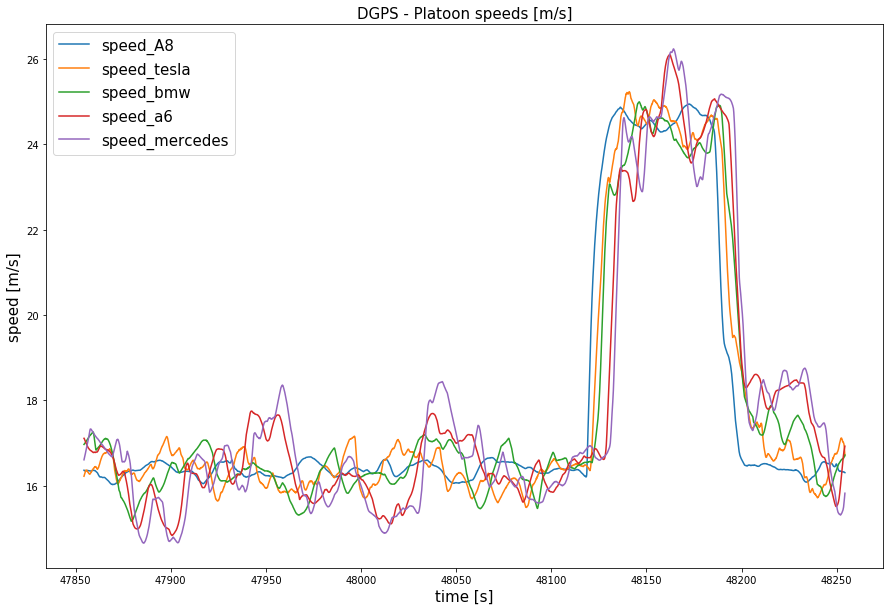

In [165]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(df_d.loc[:, 'Time(s)'], df_d.loc[:, 'Velocity(m/s) A8 azd'])
ax.plot(df_d.loc[:, 'Time(s)'], df_d.loc[:, 'Velocity(m/s) Tesla azd'])
ax.plot(df_d.loc[:, 'Time(s)'], df_d.loc[:, 'Velocity(m/s) BMW azd'])
ax.plot(df_d.loc[:, 'Time(s)'], df_d.loc[:, 'Velocity(m/s) A6 azd'])
ax.plot(df_d.loc[:, 'Time(s)'], df_d.loc[:, 'Velocity(m/s) Mercedes azd'])
ax.legend(['speed_A8', 'speed_tesla', 'speed_bmw', 'speed_a6', 'speed_mercedes'], fontsize=15)
ax.set_xlabel(xlabel='time [s]', fontsize=15)
ax.set_ylabel(ylabel='speed [m/s]', fontsize=15)
ax.set_title('DGPS - Platoon speeds [m/s]', fontsize=15) 
plt.plot()

[]

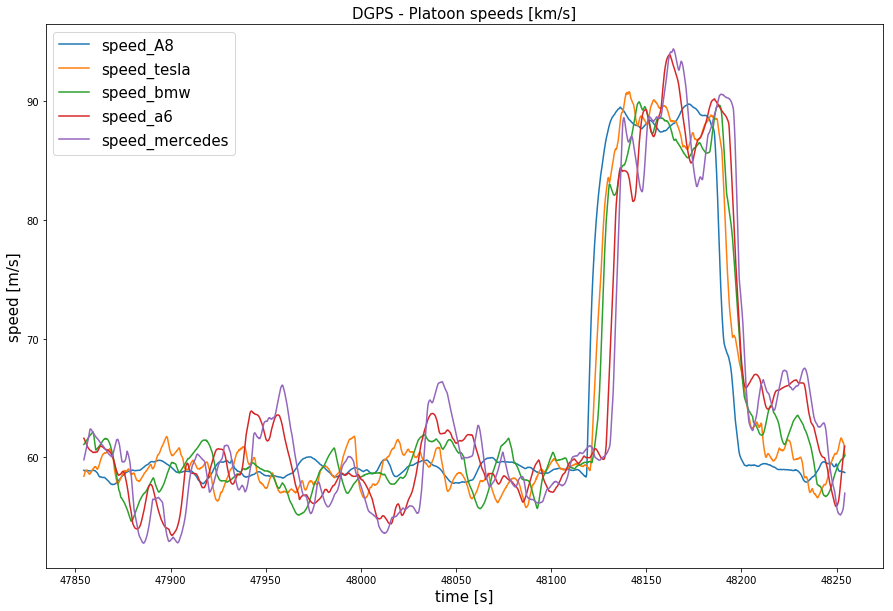

In [166]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(df_d.loc[:, 'Time(s)'], df_d.loc[:, 'Velocity(m/s) A8 azd'] * 3600 / 1000)
ax.plot(df_d.loc[:, 'Time(s)'], df_d.loc[:, 'Velocity(m/s) Tesla azd'] * 3600 / 1000)
ax.plot(df_d.loc[:, 'Time(s)'], df_d.loc[:, 'Velocity(m/s) BMW azd'] * 3600 / 1000)
ax.plot(df_d.loc[:, 'Time(s)'], df_d.loc[:, 'Velocity(m/s) A6 azd'] * 3600 / 1000)
ax.plot(df_d.loc[:, 'Time(s)'], df_d.loc[:, 'Velocity(m/s) Mercedes azd'] * 3600 / 1000)
ax.legend(['speed_A8', 'speed_tesla', 'speed_bmw', 'speed_a6', 'speed_mercedes'], fontsize=15)
ax.set_xlabel(xlabel='time [s]', fontsize=15)
ax.set_ylabel(ylabel='speed [m/s]', fontsize=15)
ax.set_title('DGPS - Platoon speeds [km/s]', fontsize=15) 
plt.plot()

[]

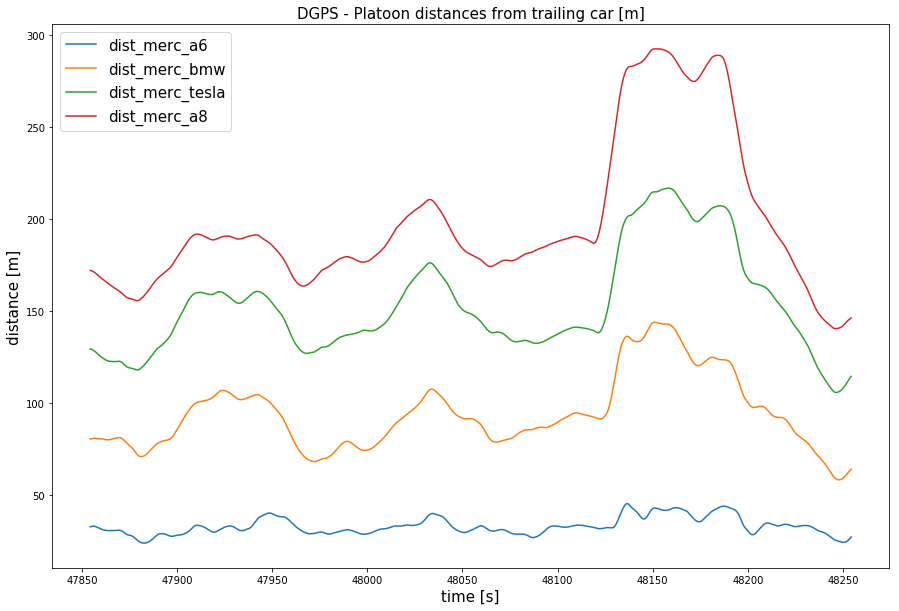

In [158]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(df_d.loc[:, 'Time(s)'], df_d.loc[:, 'dist_merc_a6'])
ax.plot(df_d.loc[:, 'Time(s)'], df_d.loc[:, 'dist_merc_bmw'])
ax.plot(df_d.loc[:, 'Time(s)'], df_d.loc[:, 'dist_merc_tesla'])
ax.plot(df_d.loc[:, 'Time(s)'], df_d.loc[:, 'dist_merc_a8'])
ax.legend(['dist_merc_a6', 'dist_merc_bmw', 'dist_merc_tesla', 'dist_merc_a8'], fontsize=15)
ax.set_xlabel(xlabel='time [s]', fontsize=15)
ax.set_ylabel(ylabel='distance [m]', fontsize=15)
ax.set_title('DGPS - Platoon distances from trailing car [m]', fontsize=15) 
plt.plot()

Checking a smaller range:

[]

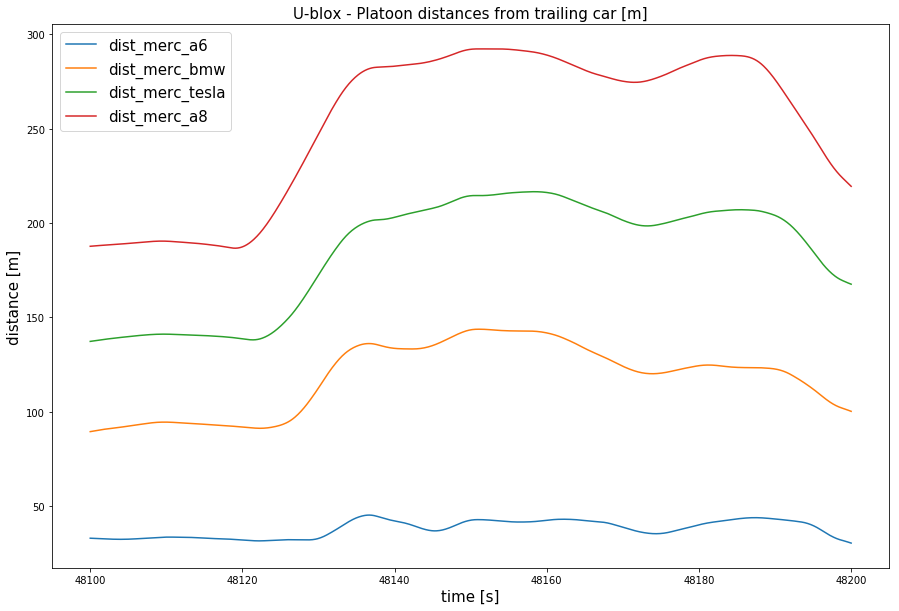

In [159]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(df_d.loc[2456:3456, 'Time(s)'], df_d.loc[2456:3456, 'dist_merc_a6'])
ax.plot(df_d.loc[2456:3456, 'Time(s)'], df_d.loc[2456:3456, 'dist_merc_bmw'])
ax.plot(df_d.loc[2456:3456, 'Time(s)'], df_d.loc[2456:3456, 'dist_merc_tesla'])
ax.plot(df_d.loc[2456:3456, 'Time(s)'], df_d.loc[2456:3456, 'dist_merc_a8'])
ax.legend(['dist_merc_a6', 'dist_merc_bmw', 'dist_merc_tesla', 'dist_merc_a8'], fontsize=15)
ax.set_xlabel(xlabel='time [s]', fontsize=15)
ax.set_ylabel(ylabel='distance [m]', fontsize=15)
ax.set_title('U-blox - Platoon distances from trailing car [m]', fontsize=15) 
plt.plot()

# Comparing U-blox and DGPS

## Distances

[]

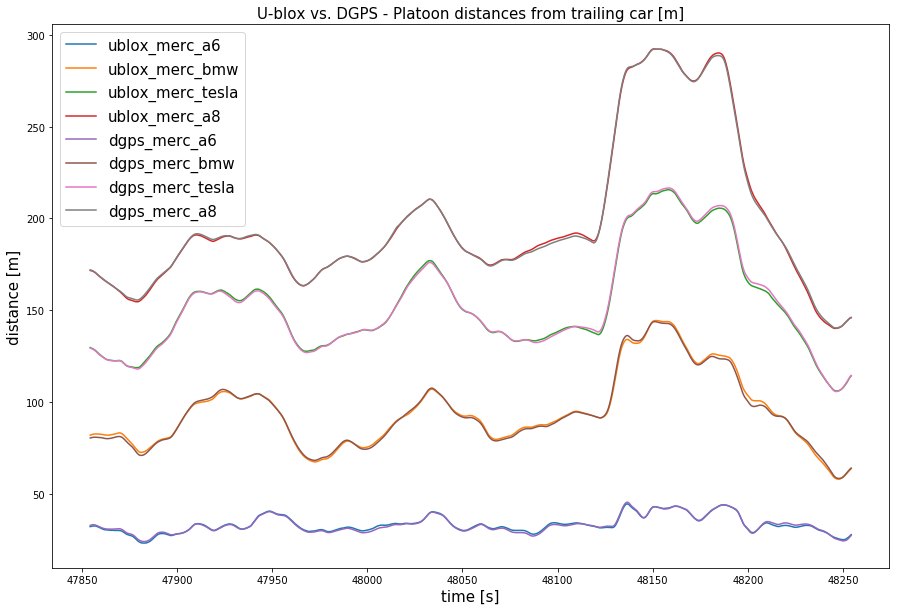

In [160]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(df_u.loc[:, 'Time(s)'], df_u.loc[:, 'dist_merc_a6'])
ax.plot(df_u.loc[:, 'Time(s)'], df_u.loc[:, 'dist_merc_bmw'])
ax.plot(df_u.loc[:, 'Time(s)'], df_u.loc[:, 'dist_merc_tesla'])
ax.plot(df_u.loc[:, 'Time(s)'], df_u.loc[:, 'dist_merc_a8'])
ax.plot(df_d.loc[:, 'Time(s)'], df_d.loc[:, 'dist_merc_a6'])
ax.plot(df_d.loc[:, 'Time(s)'], df_d.loc[:, 'dist_merc_bmw'])
ax.plot(df_d.loc[:, 'Time(s)'], df_d.loc[:, 'dist_merc_tesla'])
ax.plot(df_d.loc[:, 'Time(s)'], df_d.loc[:, 'dist_merc_a8'])
ax.legend(['ublox_merc_a6', 'ublox_merc_bmw', 'ublox_merc_tesla', 'ublox_merc_a8',
           'dgps_merc_a6', 'dgps_merc_bmw', 'dgps_merc_tesla', 'dgps_merc_a8'], fontsize=15)
ax.set_xlabel(xlabel='time [s]', fontsize=15)
ax.set_ylabel(ylabel='distance [m]', fontsize=15)
ax.set_title('U-blox vs. DGPS - Platoon distances from trailing car [m]', fontsize=15) 
plt.plot()

Checking a smaller range:

[]

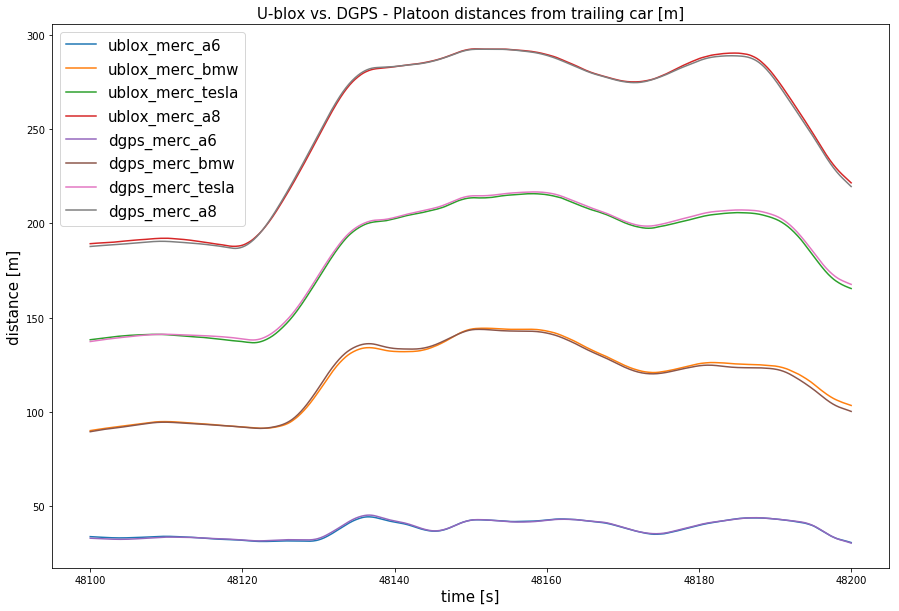

In [161]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(df_u.loc[2456:3456, 'Time(s)'], df_u.loc[2456:3456, 'dist_merc_a6'])
ax.plot(df_u.loc[2456:3456, 'Time(s)'], df_u.loc[2456:3456, 'dist_merc_bmw'])
ax.plot(df_u.loc[2456:3456, 'Time(s)'], df_u.loc[2456:3456, 'dist_merc_tesla'])
ax.plot(df_u.loc[2456:3456, 'Time(s)'], df_u.loc[2456:3456, 'dist_merc_a8'])
ax.plot(df_d.loc[2456:3456, 'Time(s)'], df_d.loc[2456:3456, 'dist_merc_a6'])
ax.plot(df_d.loc[2456:3456, 'Time(s)'], df_d.loc[2456:3456, 'dist_merc_bmw'])
ax.plot(df_d.loc[2456:3456, 'Time(s)'], df_d.loc[2456:3456, 'dist_merc_tesla'])
ax.plot(df_d.loc[2456:3456, 'Time(s)'], df_d.loc[2456:3456, 'dist_merc_a8'])
ax.legend(['ublox_merc_a6', 'ublox_merc_bmw', 'ublox_merc_tesla', 'ublox_merc_a8',
           'dgps_merc_a6', 'dgps_merc_bmw', 'dgps_merc_tesla', 'dgps_merc_a8'], fontsize=15)
ax.set_xlabel(xlabel='time [s]', fontsize=15)
ax.set_ylabel(ylabel='distance [m]', fontsize=15)
ax.set_title('U-blox vs. DGPS - Platoon distances from trailing car [m]', fontsize=15) 
plt.plot()

## Differences in the distance

Checking the difference:

[]

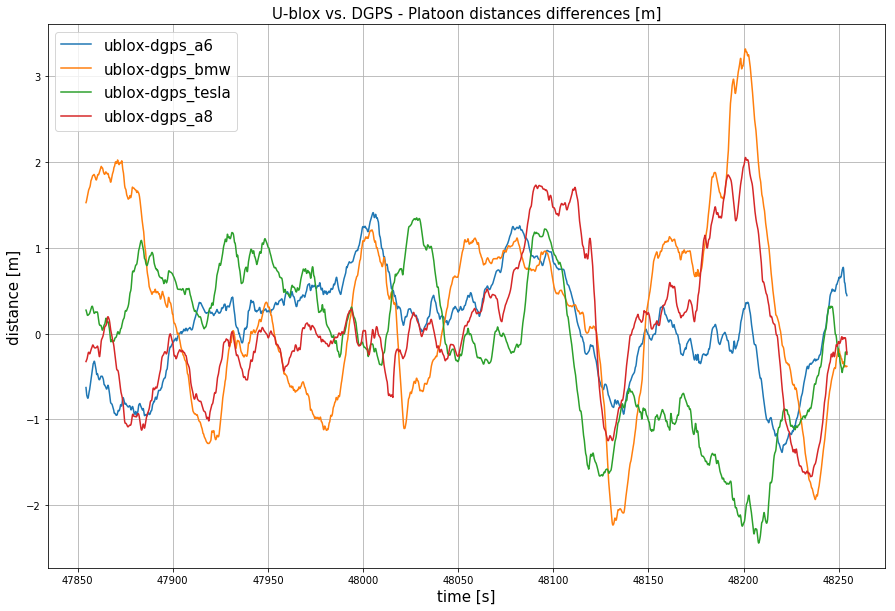

In [179]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(df_u.loc[:, 'Time(s)'], df_u.loc[:, 'dist_merc_a6'] - df_d.loc[:, 'dist_merc_a6'])
ax.plot(df_u.loc[:, 'Time(s)'], df_u.loc[:, 'dist_merc_bmw'] - df_d.loc[:, 'dist_merc_bmw'])
ax.plot(df_u.loc[:, 'Time(s)'], df_u.loc[:, 'dist_merc_tesla'] - df_d.loc[:, 'dist_merc_tesla'])
ax.plot(df_u.loc[:, 'Time(s)'], df_u.loc[:, 'dist_merc_a8'] - df_d.loc[:, 'dist_merc_a8'])
ax.legend(['ublox-dgps_a6', 'ublox-dgps_bmw', 'ublox-dgps_tesla', 'ublox-dgps_a8'], fontsize=15)
ax.set_xlabel(xlabel='time [s]', fontsize=15)
ax.set_ylabel(ylabel='distance [m]', fontsize=15)
ax.set_title('U-blox vs. DGPS - Platoon distances differences [m]', fontsize=15)
ax.grid()
plt.plot()

[]

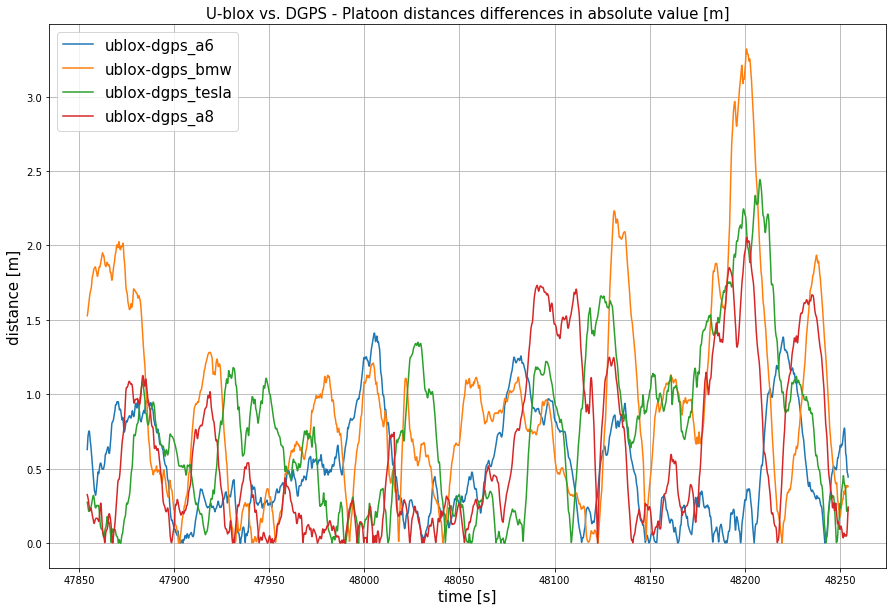

In [180]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(df_u.loc[:, 'Time(s)'], abs(df_u.loc[:, 'dist_merc_a6'] - df_d.loc[:, 'dist_merc_a6']))
ax.plot(df_u.loc[:, 'Time(s)'], abs(df_u.loc[:, 'dist_merc_bmw'] - df_d.loc[:, 'dist_merc_bmw']))
ax.plot(df_u.loc[:, 'Time(s)'], abs(df_u.loc[:, 'dist_merc_tesla'] - df_d.loc[:, 'dist_merc_tesla']))
ax.plot(df_u.loc[:, 'Time(s)'], abs(df_u.loc[:, 'dist_merc_a8'] - df_d.loc[:, 'dist_merc_a8']))
ax.legend(['ublox-dgps_a6', 'ublox-dgps_bmw', 'ublox-dgps_tesla', 'ublox-dgps_a8'], fontsize=15)
ax.set_xlabel(xlabel='time [s]', fontsize=15)
ax.set_ylabel(ylabel='distance [m]', fontsize=15)
ax.set_title('U-blox vs. DGPS - Platoon distances differences in absolute value [m]', fontsize=15)
ax.grid()
plt.plot()

For instance, for the distance between the Mercedes and the next car (the A6):

In [172]:
print('{:.4}% of the rows are within 1m difference'.format(
    sum(abs(df_u.loc[:, 'dist_merc_a6'] - df_d.loc[:, 'dist_merc_a6']) < 1) / df_u.shape[0] * 100))

90.12% of the rows are within 1m difference


In [178]:
print('{:.4}% of the rows are within 1.25m difference'.format(
    sum(abs(df_u.loc[:, 'dist_merc_a6'] - df_d.loc[:, 'dist_merc_a6']) < 1.25) / df_u.shape[0] * 100))

97.47% of the rows are within 1.25m difference


# Bonus
## Animations

Considering the data we have, a good visualization technique would be to plot the platoon interactively, in the form of a GIF.  
Going back to the GPS data from the Garmin camera, if we plot **all** positions of both cars:

[]

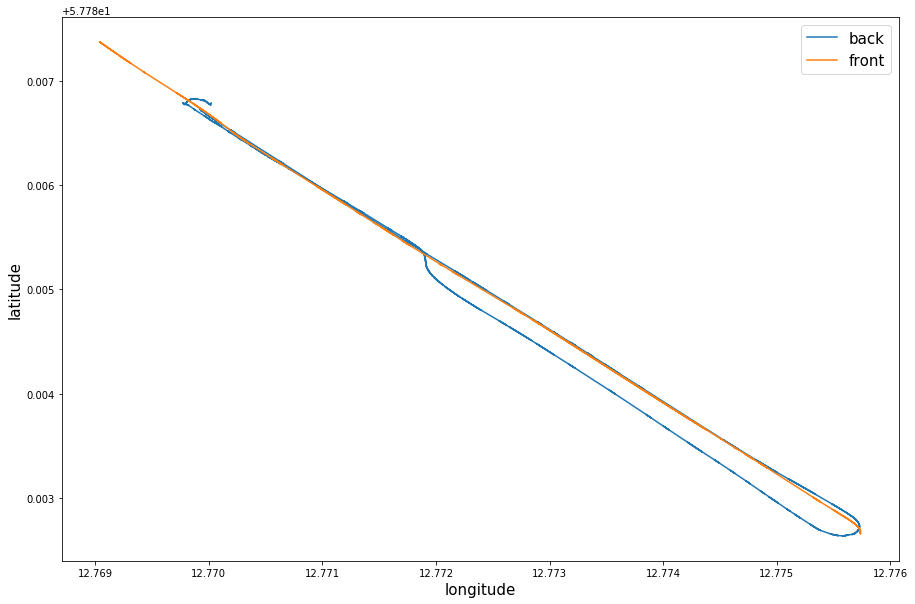

In [181]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(df_m.position_long_b, df_m.position_lat_b)
ax.plot(df_m.position_long_f, df_m.position_lat_f)
ax.legend(['back', 'front'], fontsize=15)
ax.set_xlabel(xlabel='longitude', fontsize=15)
ax.set_ylabel(ylabel='latitude', fontsize=15)
plt.plot()

Like this we can get an idea of the road shape, but let see how to animate it using `matplotlib`:

In [188]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

ax.set_xlabel(xlabel='longitude', fontsize=15)
ax.set_ylabel(ylabel='latitude', fontsize=15)
ax.set_xlim((12.768705171067266, 12.77607119595632))
ax.set_ylim((57.78239703085273, 57.78760878089816))
ax.set_title('Car trajectories', fontsize=15) 
ln, = plt.plot([], [], 'bo')
ln1, = plt.plot([], [], 'go')
ln2, = plt.plot([], [], 'r', linewidth=0.5)
ln3 = plt.annotate('', xy=[12.768705171067266,57.78239703085273], color='r', fontsize=15)
    
def update(frame):
    long_b, lat_b, long_f, lat_f = df_m.loc[10*frame, ['position_long_b', 'position_lat_b', 
                                                      'position_long_f', 'position_lat_f']]
    ln.set_data(long_b, lat_b)
    ln1.set_data(long_f, lat_f)
    ln2.set_data([[long_b, long_f],
                  [lat_b, lat_f]])
    ln3.set_text(str(round(df_m.dist_enu.iloc[10*frame], 1)) + 'm')
    #ln3.xytext = (12.7688, 57.7824)
    ln3.set_position((min(long_b, long_f) + abs(long_b - long_f)/2, 
                      min(lat_b, lat_f) + abs(lat_b - lat_f)/2))
    ax.legend(['back', 'front'], fontsize=15)
    return ln, ln1, ln2
    
anim = animation.FuncAnimation(fig, update, frames=df_m.shape[0]//10, repeat=True)
anim.save('./graphs/2-platoon.mp4')
plt.close(fig)

/usr/local/lib/python3.7/virtual-envs/my-test-3.7/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


<video controls src="./graphs/2-platoon.mp4" />

And for the big 5-car platoon (we just display the distance to the next and the first car in this case):

In [35]:
cols = [c for c in df_d.columns if  'E' in c or 'N' in c]

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

ax.set_xlabel(xlabel='E coordinate [m]', fontsize=15)
ax.set_ylabel(ylabel='N coordinate [m]', fontsize=15)
ax.set_xlim((-640, 640))
ax.set_ylim((-1200, 1200))
ax.set_title('Car trajectories at AstaZero', fontsize=15) 
bg, = plt.plot([], [], 'gray', alpha=0.3, linewidth=2, label='_nolegend_')
car, = plt.plot([], [], 'bo', markersize=7)
car1, = plt.plot([], [], 'go', markersize=7)
car2, = plt.plot([], [], 'yo', markersize=7)
car3, = plt.plot([], [], 'co', markersize=7)
car4, = plt.plot([], [], 'ro', markersize=7)
ln, = plt.plot([], [], 'r', linewidth=0.5)
ln1, = plt.plot([], [], 'r', linewidth=0.5)
ln2, = plt.plot([], [], 'r', linewidth=0.5)
ln3, = plt.plot([], [], 'r', linewidth=0.5)
ann = plt.annotate('', xy=[171,645], color='r', fontsize=15)
#ann1 = plt.annotate('', xy=[171,645], color='r', fontsize=15)
#ann2 = plt.annotate('', xy=[171,645], color='r', fontsize=15)
ann3 = plt.annotate('', xy=[171,645], color='r', fontsize=15)

    
def update(frame):
    E_A8, N_A8, E_Tesla, N_Tesla, E_BMW, N_BMW, E_A6, N_A6, E_Merc, N_Merc = df_d.loc[10*frame, cols]
    bg.set_data([df_d['E A8 azd'], df_d['N A8 azd']])
    # Car locations
    car.set_data(E_A8, N_A8)
    car1.set_data(E_Tesla, N_Tesla)
    car2.set_data(E_BMW, N_BMW)
    car3.set_data(E_A6, N_A6)
    car4.set_data(E_Merc, N_Merc)
    # Lines for car distances
    ln.set_data([[E_Merc, E_A6],
                 [N_Merc, N_A6]])
    ln1.set_data([[E_Merc, E_BMW],
                 [N_Merc, N_BMW]])
    ln2.set_data([[E_Merc, E_Tesla],
                 [N_Merc, N_Tesla]])
    ln3.set_data([[E_Merc, E_A8],
                 [N_Merc, N_A8]])
    # Annotations for car distances
    ann.set_text(str(round(df_d.dist_merc_a6.iloc[10*frame], 1)) + 'm')
    ann.set_position((min(E_Merc, E_A6) + abs(E_Merc - E_A6)/2,
                      min(N_Merc, N_A6) + abs(N_Merc - N_A6)/2))
    #ann1.set_text(str(round(df_d.dist_merc_bmw.iloc[10*frame], 1)) + 'm')
    #ann1.set_position((min(E_Merc, E_BMW) + abs(E_Merc - E_BMW)/2,
    #                  min(N_Merc, N_BMW) + abs(N_Merc - N_BMW)/2))
    #ann2.set_text(str(round(df_d.dist_merc_tesla.iloc[10*frame], 1)) + 'm')
    #ann2.set_position((min(E_Merc, E_Tesla) + abs(E_Merc - E_Tesla)/2,
    #                  min(N_Merc, N_Tesla) + abs(N_Merc - N_Tesla)/2))
    ann3.set_text(str(round(df_d.dist_merc_a8.iloc[10*frame], 1)) + 'm')
    ann3.set_position((min(E_Merc, E_A8) + abs(E_Merc - E_A8)/2,
                      min(N_Merc, N_A8) + abs(N_Merc - N_A8)/2))
    
    ax.legend(['A8', 'Tesla', 'BMW', 'A6', 'Merc'], fontsize=15)
    return bg, car, car1, car2, car3, car4, ln, ln1, ln2, ln3, ann, ann3#, ann2, ann3

anim = animation.FuncAnimation(fig, update, frames=df_d.shape[0]//10, repeat=True)
anim.save('./graphs/5-platoon.mp4')
plt.close(fig)

/usr/local/lib/python3.7/virtual-envs/my-test-3.7/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


<video controls src="./graphs/5-platoon.mp4" />

## Smoothing signals

This two methods could be used to try to smooth signals:

In [ ]:
from scipy import signal

def medmav(Ssignal, N, Nm):
    '''
    Smoothing of a signal. We use a median filter and a moving average
    :param Ssignal:
    :param N: smoothing parameter
    :param Nm: filtering parameter
    :return: res : Smoothed signal
    
    https://en.wikipedia.org/wiki/Moving_average
    '''

    B = np.ones((N, 1), dtype='float64').flatten()
    A = N * np.ones((1, 1), dtype='float64').flatten()

    # Apply median filtering to remove outliers
    res = signal.medfilt(Ssignal, Nm)

    # Apply smoothing
    res = signal.filtfilt(B, A, res)

    return res


def butrw(ssignal, order, cfreq):
    '''
    https://en.wikipedia.org/wiki/Butterworth_filter
    '''
    B, A = signal.butter(order, cfreq, output='ba')
    res = signal.filtfilt(B, A, ssignal)

    return res

## Interpolation

Also, the following code could be used for interpolation of signals:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from scipy.interpolate import *

path = '.'
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
out_path = '.'

for file in onlyfiles:
    df_un = pd.read_csv(path + '/' + file, index_col=0)
    time = np.arange(np.round(df_un['Time(s)'].min(), 1), 
                     np.round(df_un['Time(s)'].max(), 1), 0.1)
    df_interp = pd.DataFrame({'Time(s)': time})
    # plt.plot(time,'x')
    # plt.plot(df_un['Time(s)'],'x')
    # plt.show()

    for col in df_un.columns:
        if col != 'Time(s)':

            a = df_un[['Time(s)', col]].dropna(axis=0)

            cs = CubicSpline(a['Time(s)'], a[col])
            df_interp[col] = cs(time)
            max_speed = a[col].max()
            df_interp[col] = cs(time)
            if col[:3] == 'Vel':
                df_interp.loc[df_interp[col] > max_speed, col] = max_speed
                df_interp.loc[df_interp[col] < 0, col] = 0

            if col[:3] == 'Vel':
                metric = np.diff(a['Time(s)'])
                metric = (np.append([0], metric) + np.append(metric, [0]))/2
                df_interp['metric'+col[13:]
                          ] = np.interp(time, a['Time(s)'], metric)

    df_interp.to_csv(out_path + '/' + file)
    
plt.show()